<div style="display:fill;
           background-color:#FFFFE0;
           letter-spacing:0.5px;border-bottom: 2px solid black;">
<img src="https://raw.githubusercontent.com/IqmanS/Machine-Learning-Notebooks/main/enefit/enefit-banner.jpg">
<H2 style="padding: 20px; color:black; font-weight:600; font-family: 'Garamond', 'Lucida Sans', sans-serif; text-align: center; font-size: 38px;">🧫 Schema and Features 💎 </H2>
</div>

In [1]:
from IPython.display import Image, display, clear_output
import warnings
warnings.filterwarnings("ignore")

In [2]:
%%time
!pip install "featuretools[dask,premium,tsfresh]"
!pip install "dask-ml[complete]"

clear_output()

CPU times: user 2.38 s, sys: 472 ms, total: 2.85 s
Wall time: 1min 24s


In [3]:
%%time
import os, sys, shutil
import json, yaml
import base64
import re
from tqdm import tqdm
from typing import List, Tuple, Optional, Union
from itertools import product, combinations

import math
import numpy as np
import pandas as pd
import polars as pl
import dask as dk

import featuretools as ft
from featuretools.primitives.utils import (
    get_default_aggregation_primitives, get_aggregation_primitives,
    get_default_transform_primitives, get_transform_primitives,
    list_primitives, summarize_primitives,
)

from woodwork.logical_types import (Boolean, Categorical, Ordinal, 
                                    Datetime, Timedelta, 
                                    Double, Integer, LatLong,)

CPU times: user 3.33 s, sys: 810 ms, total: 4.15 s
Wall time: 6.6 s


In [4]:
logical_types = ft.list_logical_types().drop(columns=['description','is_registered'])
logical_types[logical_types['physical_type'] != 'string'].T

,1,2,3,4,5,6,7,8,9,10,14,15,16,18,21,22,23
name,Age,AgeFractional,AgeNullable,Boolean,BooleanNullable,Categorical,CountryCode,CurrencyCode,Datetime,Double,Integer,IntegerNullable,LatLong,Ordinal,PostalCode,SubRegionCode,Timedelta
type_string,age,age_fractional,age_nullable,boolean,boolean_nullable,categorical,country_code,currency_code,datetime,double,integer,integer_nullable,lat_long,ordinal,postal_code,sub_region_code,timedelta
physical_type,int64,float64,Int64,bool,boolean,category,category,category,datetime64[ns],float64,int64,Int64,object,category,category,category,timedelta64[ns]
standard_tags,{numeric},{numeric},{numeric},{},{},{category},{category},{category},{},{numeric},{numeric},{numeric},{},{category},{category},{category},{}
is_default_type,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
parent_type,Integer,Double,IntegerNullable,BooleanNullable,None,None,Categorical,Categorical,None,None,IntegerNullable,None,None,Categorical,Categorical,Categorical,Unknown


In [5]:
def extract_input_types(column_schemas: str, type_in: str) -> str:
    
    type_in = type_in.lower()
    if 'semantic' in type_in:
        trigger_word = 'Semantic Tags = '
        pattern = trigger_word + '\[(.*?)\]'
    elif 'logical' in type_in:
        trigger_word = 'Logical Type = '
        pattern = trigger_word + '([a-zA-Z]+)'
        
    try:
        found = re.findall(pattern, column_schemas)
    except AttributeError:
        found = []
        
    found = [f.replace(trigger_word, '')\
              .replace("'",'') for f in found]
    return list(set(found))

shorten_valid_inputs = lambda x: x.replace('ColumnSchema ','')

In [6]:
primitives = ft.list_primitives()
primitives['semantic_inputs'] = primitives['valid_inputs'].apply(extract_input_types, type_in='semantic')
primitives['logical_inputs'] = primitives['valid_inputs'].apply(extract_input_types, type_in='logical')
primitives_agg = primitives[primitives['type'] == 'aggregation']
primitives_trx = primitives[primitives['type'] == 'transform']

display(primitives_agg[~primitives_agg['dask_compatible']].drop(columns=['type','description','valid_inputs','return_type']).T)
display(primitives_trx[~primitives_trx['dask_compatible']].drop(columns=['type','description','valid_inputs','return_type']).T)

,1,2,3,4,5,6,8,9,10,11,...,54,55,56,57,59,60,61,62,63,64
name,count_below_mean,count_greater_than,date_first_event,n_most_common_frequency,time_since_first,avg_time_between,last,n_unique_weeks,num_zero_crossings,median,...,has_no_duplicates,first,n_unique_days,skew,num_consecutive_less_mean,kurtosis,time_since_last_max,min_count,is_monotonically_decreasing,max_consecutive_negatives
dask_compatible,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
spark_compatible,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
semantic_inputs,[numeric],[numeric],[time_index],[category],[time_index],[time_index],[],[],[numeric],[numeric],...,"[category, numeric]",[],[],[numeric],[numeric],[numeric],"[time_index, numeric]",[numeric],[numeric],[]
logical_inputs,[],[],[Datetime],[],[Datetime],[Datetime],[],[Datetime],[],[],...,[],[],[Datetime],[],[],"[Integer, Double]",[Datetime],[],[],"[Integer, Double]"


,65,66,67,69,72,74,75,76,78,79,...,185,187,188,189,191,192,194,196,198,200
name,diff_datetime,mean_characters_per_word,is_first_week_of_month,numeric_lag,latitude,season,number_of_hashtags,total_word_length,count_string,date_to_time_zone,...,url_to_domain,cum_count,expanding_max,percentile,absolute_diff,cum_sum,rolling_min,rolling_trend,number_of_unique_words,num_unique_separators
dask_compatible,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
spark_compatible,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
semantic_inputs,[],[],[],"[time_index, numeric]",[],[],[],[],[],[],...,[],"[category, foreign_key]","[time_index, numeric]",[numeric],[numeric],[numeric],"[time_index, numeric]","[time_index, numeric]",[],[]
logical_inputs,[Datetime],[NaturalLanguage],[Datetime],[],[LatLong],[Datetime],[NaturalLanguage],[NaturalLanguage],[NaturalLanguage],[Datetime],...,[URL],[],[Datetime],[],[],[],[Datetime],[Datetime],[NaturalLanguage],[NaturalLanguage]


In [7]:
def make_flowchart(graph: str):
    graph_bytes = graph.encode("ascii")
    base64_bytes = base64.b64encode(graph_bytes)
    base64_string = base64_bytes.decode("ascii")
    display(
        Image(url="https://mermaid.ink/img/" + base64_string)
    )

In [8]:
def transform_east_north_to_magnitude_degree(east: np.array or pd.Series, 
                                            north: np.array or pd.Series,):
    magnitude = np.sqrt(east**2 + north**2)
    degree = np.arctan2(east, north) * 180 / np.pi + 180
    degree = np.where(degree < 0, degree+360, degree)
    return magnitude, degree
    
def transform_magnitude_degree_to_east_north(magnitude: np.array or pd.Series, 
                                                degree: np.array or pd.Series,):
    east = -magnitude * np.sin(np.radians(degree))
    north = -magnitude * np.cos(np.radians(degree))
    return east, north

In [9]:
month_mapping = {
    'jan': 'January',
    'feb': 'February',
    'mrt': 'March',
    'mar': 'March',
    'apr': 'April',
    'mei': 'May',
    'jun': 'June',
    'aug': 'August',
    'dec': 'December'
}

def convert_month_abbr(date):    
    parts = date.split()
    if len(parts) == 2:
        if parts[1].isdigit():
            month, day = parts
        else:
            day, month = parts
        if month.lower() in month_mapping:
            return f"{day} {month_mapping[month.lower()]}"
    return pd.NaT

def get_holidays(years: Union[int, List[int]], country: str):
    if isinstance(years, List) is False:
        years = [years]
    
    DF = pd.DataFrame()
    pbar = tqdm(years)
    for year in pbar:
        pbar.set_description(f'Year {year}')
        
        # Query holidays from website
        try:
            url = f'https://www.timeanddate.com/holidays/{country}/{year}?hol=1'
            df = pd.read_html(url)[0]
        except:
            continue

        # Flatten the MultiIndex columns if present
        df.columns = df.columns.get_level_values(0)

        # Select the desired columns
        df = df[['Date', 'Name', 'Type']]

        # Filter for national holidays only
        df = df[df['Type'] == 'National holiday']

        # Add a 'Year' column to differentiate between years
        df['Year'] = year
        
        # Aggregations
        DF = pd.concat([DF, df], ignore_index=True)
    
    # Convert to datetime
    DF['Date'] = DF[ 'Date'].apply(convert_month_abbr)
    DF.dropna(subset='Date', axis=0, inplace=True)
    DF['date'] = DF[['Date','Year']].apply(lambda x: f"{x.Date} {x.Year}", axis=1)
    DF['date'] = DF[ 'date'].apply(pd.to_datetime, errors='coerce').dt.date
    DF.dropna(subset='date', axis=0, inplace=True)

    return DF[['date', 'Name', 'Type']]
        
holidays = get_holidays(list(range(2020, 2050)), country='estonia')
holidays

Year 2049: 100%|██████████| 30/30 [00:04<00:00,  6.55it/s]


,date,Name,Type
0,2020-01-01,New Year's Day,National holiday
1,2020-02-24,Independence Day,National holiday
2,2020-04-10,Good Friday,National holiday
3,2020-04-12,Easter Sunday,National holiday
4,2020-05-01,Labor Day,National holiday
...,...,...,...
247,2040-06-24,Midsummer Day,National holiday
248,2040-08-20,Independence Restoration Day,National holiday
249,2040-12-24,Christmas Eve,National holiday
250,2040-12-25,Christmas Day,National holiday


<div>
    <h1 style="font-family:  'Garamond', 'Lucida Sans', sans-serif; text-align: center; color: #263A29; font-weight: bold; font-size: 36px;">
    Data Preprocessing
    </h1>
</div>
<hr>

# [Data & Insights](https://www.kaggle.com/code/mrriandmstique/enefit-data-and-insights)

In [10]:
%%time
capacity = pd.read_csv('/kaggle/input/predict-energy-behavior-of-prosumers/client.csv')
prosumers = pd.read_csv('/kaggle/input/predict-energy-behavior-of-prosumers/train.csv')

CPU times: user 2.08 s, sys: 461 ms, total: 2.54 s
Wall time: 3.22 s


In [11]:
%%time

# Extract client = (county, product_type, is_business)
client_columns = ['county','product_type','is_business']
client_mapping = lambda x: f"C{x.county:02d}_P{x.product_type:03d}_B{x.is_business}"

clients = pd.concat([ capacity[client_columns], 
                     prosumers[client_columns]], axis=0).drop_duplicates()
clients['client_id'] = clients[client_columns].apply(client_mapping, axis=1)
display(clients.tail(3))

# Extract county
counties = clients.groupby(['county']).agg({'product_type': 'nunique'})
display(counties.T)

# Reduce into daily 2-target
targets = pd.pivot_table(prosumers, index=['datetime']+client_columns,
                                  columns=['is_consumption'],
                                   values=['target'])
targets.reset_index(drop=False, inplace=True)
targets.columns = [c1 if c1 != 'target' else ('consumption' if c2 else 'production')
                     for c1, c2 in targets.columns]

# Parse date
capacity['date'] = pd.to_datetime(capacity['date'])
targets['datetime'] = pd.to_datetime(targets['datetime'])
targets['date'] = targets['datetime'].dt.date

# Undo (just for testing)
# prosumers = pd.melt(targets, id_vars=['datetime','county','product_type','is_business'], 
#                           value_vars=['production','consumption'], 
#                           value_name='target',
#                             var_name='is_consumption')\
#                 .replace(to_replace={'is_consumption': {'production': 0,
#                                                        'consumption': 1,}})

# Mapping client-id
capacity = capacity.merge(clients, on=client_columns, how='left')
targets = targets.merge(clients, on=client_columns, how='left')

# Display
display(capacity.tail(3))
display(targets.tail(3))

,county,product_type,is_business,client_id
7647,4,1,1,C04_P001_B1
9689,11,0,1,C11_P000_B1
27949,14,2,1,C14_P002_B1


county,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product_type,4,2,2,2,3,3,1,4,2,2,3,4,1,2,3,3


,product_type,county,eic_count,installed_capacity,is_business,date,data_block_id,client_id
41916,0,15,15,620.0,1,2023-05-29,637,C15_P000_B1
41917,1,15,20,624.5,1,2023-05-29,637,C15_P001_B1
41918,3,15,55,2188.2,1,2023-05-29,637,C15_P003_B1


,datetime,county,product_type,is_business,production,consumption,date,client_id
1008909,2023-05-31 23:00:00,15,1,1,0.000,28.404,2023-05-31,C15_P001_B1
1008910,2023-05-31 23:00:00,15,3,0,2.287,117.332,2023-05-31,C15_P003_B0
1008911,2023-05-31 23:00:00,15,3,1,0.000,196.240,2023-05-31,C15_P003_B1


CPU times: user 3.07 s, sys: 389 ms, total: 3.46 s
Wall time: 3.48 s


In [12]:
%%time
geo_columns = ['longitude','latitude',]

weather_station = pd.read_csv('/kaggle/input/predict-energy-behavior-of-prosumers/weather_station_to_county_mapping.csv')
weather_station['county'] = weather_station['county'].fillna(-1).astype(int)
weather_station['station'] = weather_station.index.astype(int)
weather_station[geo_columns] = weather_station[geo_columns].round(1)
weather_station.T

CPU times: user 8.03 ms, sys: 0 ns, total: 8.03 ms
Wall time: 11.4 ms


,0,1,2,3,4,5,6,7,8,9,...,102,103,104,105,106,107,108,109,110,111
county_name,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Ida-Virumaa,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
longitude,21.7,21.7,21.7,21.7,21.7,21.7,21.7,21.7,22.2,22.2,...,27.7,27.7,28.2,28.2,28.2,28.2,28.2,28.2,28.2,28.2
latitude,57.6,57.9,58.2,58.5,58.8,59.1,59.4,59.7,57.6,57.9,...,59.4,59.7,57.6,57.9,58.2,58.5,58.8,59.1,59.4,59.7
county,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,2,-1,-1,-1,-1,-1,-1,-1,-1,-1
station,0,1,2,3,4,5,6,7,8,9,...,102,103,104,105,106,107,108,109,110,111


In [13]:
%%time
weather_hist = pd.read_csv("/kaggle/input/predict-energy-behavior-of-prosumers/historical_weather.csv")
weather_hist["datetime"] = pd.to_datetime(weather_hist["datetime"])
weather_hist.rename(columns={'windspeed_10m'    : 'wind_speed',
                             'winddirection_10m': 'wind_direction',}, inplace=True)
weather_hist[geo_columns] = weather_hist[geo_columns].round(1)
weather_hist = weather_hist.merge(weather_station[['longitude','latitude','station']], 
                                   how='left', on=['longitude','latitude'])
weather_hist['station_dt'] = weather_hist['station'].astype(str) + '_' + weather_hist['datetime'].dt.strftime('%Y-%m-%d_%H')

# Synchronization of Measurement units
cloud_columns = [col for col in weather_hist.columns if col.startswith('cloudcover')]
weather_hist[cloud_columns] = weather_hist[cloud_columns] / 100.
weather_hist['wind_direction'] = weather_hist['wind_direction'].apply(np.radians)
# weather_hist['total_precipitation'] = weather_hist['rain'] + weather_hist['snowfall']
# weather_hist['surface_solar_radiation'] = weather_hist['direct_solar_radiation'] + weather_hist['diffuse_radiation']

# De-duplicate
weather_hist.drop_duplicates(subset=['station_dt'], inplace=True)

weather_hist[['station_dt','temperature','rain','snowfall','wind_speed','wind_direction']].T

CPU times: user 29.3 s, sys: 1.98 s, total: 31.3 s
Wall time: 32.4 s


,0,1,2,3,4,5,6,7,8,9,...,1710792,1710793,1710794,1710795,1710796,1710797,1710798,1710799,1710800,1710801
station_dt,0_2021-09-01_00,8_2021-09-01_00,16_2021-09-01_00,24_2021-09-01_00,32_2021-09-01_00,40_2021-09-01_00,48_2021-09-01_00,56_2021-09-01_00,64_2021-09-01_00,72_2021-09-01_00,...,39_2023-05-30_10,47_2023-05-30_10,55_2023-05-30_10,63_2023-05-30_10,71_2023-05-30_10,79_2023-05-30_10,87_2023-05-30_10,95_2023-05-30_10,103_2023-05-30_10,111_2023-05-30_10
temperature,14.2,13.9,14.0,14.6,15.7,16.0,12.2,12.2,12.4,12.9,...,12.1,10.1,11.5,11.3,12.0,11.7,12.3,9.8,11.7,12.0
rain,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0
snowfall,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
wind_speed,7.083333,5.111111,6.333333,8.083333,8.416667,6.388889,4.111111,4.111111,4.25,4.25,...,4.305556,4.527778,3.611111,3.138889,2.444444,1.055556,0.805556,1.972222,3.5,3.25
wind_direction,0.139626,6.265732,6.195919,5.183628,0.087266,5.183628,6.265732,6.178466,6.143559,6.126106,...,5.794493,5.462881,5.305801,5.183628,4.921828,4.415683,4.590216,4.974188,5.358161,5.305801


In [14]:
%%time
weather_fx = pd.read_csv("/kaggle/input/predict-energy-behavior-of-prosumers/forecast_weather.csv")
weather_fx[  "origin_datetime"] = pd.to_datetime(weather_fx[  "origin_datetime"]).dt.tz_localize(None)
weather_fx["forecast_datetime"] = pd.to_datetime(weather_fx["forecast_datetime"]).dt.tz_localize(None)

weather_fx.rename(columns={'10_metre_u_wind_component': 'wind_eastward',
                           '10_metre_v_wind_component': 'wind_northward',
                   'surface_solar_radiation_downwards': 'surface_solar_radiation',}, inplace=True)
weather_fx[geo_columns] = weather_fx[geo_columns].round(1)
weather_fx = weather_fx.merge(weather_station[['longitude','latitude','station']], 
                               how='left', on=['longitude','latitude'])
weather_fx['station_dt'] = weather_fx['station'].astype(str) + '_' + weather_fx['forecast_datetime'].dt.strftime('%Y-%m-%d_%H')

# Synchronization of Measurement units
weather_fx['wind_speed'], \
weather_fx['wind_direction'] = transform_east_north_to_magnitude_degree(weather_fx['wind_eastward'], 
                                                                        weather_fx['wind_northward'])
weather_fx['wind_direction'] = weather_fx['wind_direction'].apply(np.radians)
weather_fx.drop(columns=['wind_northward','wind_eastward'], inplace=True)
# weather_fx['rain'] = weather_fx['total_precipitation'] - weather_fx['snowfall']
# weather_fx['diffuse_radiation'] = weather_fx['surface_solar_radiation'] - weather_fx['direct_solar_radiation']

# De-duplicate
weather_fx.drop_duplicates(subset=['station_dt'], inplace=True)

weather_fx[['hours_ahead','station_dt','temperature','snowfall','wind_speed','wind_direction']].T

CPU times: user 1min, sys: 7.9 s, total: 1min 8s
Wall time: 1min 13s


,0,1,2,3,4,5,6,7,8,9,...,3424502,3424503,3424504,3424505,3424506,3424507,3424508,3424509,3424510,3424511
hours_ahead,1,1,1,1,1,1,1,1,1,1,...,48,48,48,48,48,48,48,48,48,48
station_dt,0_2021-09-01_03,8_2021-09-01_03,16_2021-09-01_03,24_2021-09-01_03,32_2021-09-01_03,40_2021-09-01_03,48_2021-09-01_03,56_2021-09-01_03,64_2021-09-01_03,72_2021-09-01_03,...,39_2023-06-01_02,47_2023-06-01_02,55_2023-06-01_02,63_2023-06-01_02,71_2023-06-01_02,79_2023-06-01_02,87_2023-06-01_02,95_2023-06-01_02,103_2023-06-01_02,111_2023-06-01_02
temperature,15.655786,13.003931,14.206567,14.844507,15.293848,15.448999,10.723535,10.364893,9.783228,9.965112,...,10.064355,9.821191,9.948633,10.035303,10.039697,10.150049,10.25979,10.467798,10.694116,11.233179
snowfall,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
wind_speed,9.115422,5.359379,7.558599,9.228698,9.064956,7.782256,2.659319,3.287537,2.569452,2.785693,...,7.636357,7.259251,8.077073,8.446042,8.012843,7.622088,7.853585,7.791598,7.251071,2.872061
wind_direction,0.04514,6.244674,6.08994,6.164704,6.142792,6.139522,5.739817,5.686478,5.679077,5.72259,...,5.434828,5.336876,5.190754,5.171276,5.182914,5.154071,5.212799,5.359979,5.353772,5.039545


In [15]:
%%time
electr = pd.read_csv("/kaggle/input/predict-energy-behavior-of-prosumers/electricity_prices.csv")
electr[  "origin_date"] = pd.to_datetime(electr[  "origin_date"])
electr["forecast_date"] = pd.to_datetime(electr["forecast_date"])
electr.rename(columns={  "origin_date":   "origin_datetime",
                       "forecast_date": "forecast_datetime",}, inplace=True)
display(electr.T)

gas = pd.read_csv("/kaggle/input/predict-energy-behavior-of-prosumers/gas_prices.csv")
gas[  "origin_date"] = pd.to_datetime(gas[  "origin_date"])
gas["forecast_date"] = pd.to_datetime(gas["forecast_date"])
display(gas.T)

,0,1,2,3,4,5,6,7,8,9,...,15276,15277,15278,15279,15280,15281,15282,15283,15284,15285
forecast_datetime,2021-09-01 00:00:00,2021-09-01 01:00:00,2021-09-01 02:00:00,2021-09-01 03:00:00,2021-09-01 04:00:00,2021-09-01 05:00:00,2021-09-01 06:00:00,2021-09-01 07:00:00,2021-09-01 08:00:00,2021-09-01 09:00:00,...,2023-05-30 14:00:00,2023-05-30 15:00:00,2023-05-30 16:00:00,2023-05-30 17:00:00,2023-05-30 18:00:00,2023-05-30 19:00:00,2023-05-30 20:00:00,2023-05-30 21:00:00,2023-05-30 22:00:00,2023-05-30 23:00:00
euros_per_mwh,92.51,88.9,87.35,86.88,88.43,93.58,118.7,135.44,140.72,130.0,...,19.63,13.1,11.92,9.55,82.1,82.1,150.85,82.1,82.09,-1.29
origin_datetime,2021-08-31 00:00:00,2021-08-31 01:00:00,2021-08-31 02:00:00,2021-08-31 03:00:00,2021-08-31 04:00:00,2021-08-31 05:00:00,2021-08-31 06:00:00,2021-08-31 07:00:00,2021-08-31 08:00:00,2021-08-31 09:00:00,...,2023-05-29 14:00:00,2023-05-29 15:00:00,2023-05-29 16:00:00,2023-05-29 17:00:00,2023-05-29 18:00:00,2023-05-29 19:00:00,2023-05-29 20:00:00,2023-05-29 21:00:00,2023-05-29 22:00:00,2023-05-29 23:00:00
data_block_id,1,1,1,1,1,1,1,1,1,1,...,637,637,637,637,637,637,637,637,637,637


,0,1,2,3,4,5,6,7,8,9,...,627,628,629,630,631,632,633,634,635,636
forecast_date,2021-09-01 00:00:00,2021-09-02 00:00:00,2021-09-03 00:00:00,2021-09-04 00:00:00,2021-09-05 00:00:00,2021-09-06 00:00:00,2021-09-07 00:00:00,2021-09-08 00:00:00,2021-09-09 00:00:00,2021-09-10 00:00:00,...,2023-05-21 00:00:00,2023-05-22 00:00:00,2023-05-23 00:00:00,2023-05-24 00:00:00,2023-05-25 00:00:00,2023-05-26 00:00:00,2023-05-27 00:00:00,2023-05-28 00:00:00,2023-05-29 00:00:00,2023-05-30 00:00:00
lowest_price_per_mwh,45.23,45.62,45.85,46.3,46.3,46.17,46.35,46.4,44.96,47.82,...,34.11,34.23,34.0,33.56,30.0,29.1,28.3,28.1,28.16,29.0
highest_price_per_mwh,46.32,46.29,46.4,46.8,46.58,46.95,47.6,47.64,47.72,48.29,...,37.0,39.98,35.4,36.96,35.0,34.1,34.1,34.1,36.98,34.0
origin_date,2021-08-31 00:00:00,2021-09-01 00:00:00,2021-09-02 00:00:00,2021-09-03 00:00:00,2021-09-04 00:00:00,2021-09-05 00:00:00,2021-09-06 00:00:00,2021-09-07 00:00:00,2021-09-08 00:00:00,2021-09-09 00:00:00,...,2023-05-20 00:00:00,2023-05-21 00:00:00,2023-05-22 00:00:00,2023-05-23 00:00:00,2023-05-24 00:00:00,2023-05-25 00:00:00,2023-05-26 00:00:00,2023-05-27 00:00:00,2023-05-28 00:00:00,2023-05-29 00:00:00
data_block_id,1,2,3,4,5,6,7,8,9,10,...,628,629,630,631,632,633,634,635,636,637


CPU times: user 249 ms, sys: 4.93 ms, total: 254 ms
Wall time: 284 ms


<div>
    <h1 style="font-family:  'Garamond', 'Lucida Sans', sans-serif; text-align: center; color: #263A29; font-weight: bold; font-size: 36px;">
    Data Schema
    </h1>
</div>
<hr>

# [Dask-Schema (Beta)](https://featuretools.alteryx.com/en/stable/guides/using_dask_entitysets.html)

In [16]:
# https://mermaid.live/edit
# https://fontawesome.com/v4/icons/

make_flowchart("""
    flowchart TD
        F -->|datetime| A(target)
        I[fa:fa-fire-extinguisher gas_prices] -->|date| A
        J[fa:fa-bolt electricity_prices] -->|datetime| A
        K[fa:fa-calendar holidays] -->|date| A
        A -->|client_id| C[client]
        C -->|county| M[county]
        E(fa:fa-industry weather_station) -->|county| M
        F[fa:fa-sun-o weather_history] -->|station_id| E
        G[fa:fa-snowflake-o weather_forecast] -->|station_id,datetime| F
        B[fa:fa-users prosumer] -->|target| A
        L[fa:fa-database capacity] -->|client_id| C
        D[fa:fa-user-circle-o county_name] -->|x| M
""")

In [17]:
dataframes = {
    'holidays'           :         holidays,
    'clients'            :          clients,
    'counties'           :         counties.reset_index(drop=False),
    'targets'            :          targets.reset_index(drop=False),
    'capacity'           :         capacity.reset_index(drop=False),
    'weather_station'    :  weather_station.reset_index(drop=False),
    'weather_history'    :  weather_hist,
    'weather_forecast'   :  weather_fx.reset_index(drop=False),
            'gas_prices' :         gas.reset_index(drop=False),
    'electricity_prices' :      electr.reset_index(drop=False),
}

In [18]:
schemas = [
    {
        'dataframe_name': 'clients', 
                 'index': 'client_id',
         'logical_types': {
           'Categorical': ['county','product_type','client_id'],
               'Boolean': ['is_business'],
         }
    },
    {
        'dataframe_name': 'counties', 
                 'index': 'county',
         'logical_types': {
               'Integer': ['product_type'],
         }
    },
    {
        'dataframe_name': 'targets', 
                 'index': 'index',
            'time_index': 'datetime', 
         'logical_types': {
           'Categorical': ['county','product_type','client_id'],
               'Boolean': ['is_business'],
              'Datetime': ['datetime','date'],
                'Double': ['production','consumption']
         }
    },
    {
        'dataframe_name': 'capacity', 
                 'index': 'index',
            'time_index': 'date', 
         'logical_types': {
           'Categorical': ['county','product_type','client_id'],
               'Integer': ['eic_count','data_block_id'],
                'Double': ['installed_capacity'],
               'Boolean': ['is_business'],
         }
    },
    {
        'dataframe_name': 'holidays', 
                 'index': 'date',
         'logical_types': {
           'Categorical': ['Name','Type'],
              'Datetime': ['date'],
         }
    },
    {
        'dataframe_name': 'weather_station', 
                 'index': 'station',
         'logical_types': {
           'Categorical': ['county_name','county'],
                'Double': ['latitude','longitude'],
         }
    },
    {
        'dataframe_name': 'weather_history', 
                 'index': 'station_dt',
            'time_index': 'datetime', 
         'logical_types': {
               'Integer': ['data_block_id'],
                'Double': ['temperature','dewpoint','rain','snowfall','surface_pressure'] + \
                          [s + '_radiation' for s in ['shortwave','direct_solar','diffuse']] + \
                          ['cloudcover_' + s for s in ['total','low','mid','high']] + \
                          ['wind_' + s for s in ['speed','direction',]] + \
                          ['latitude','longitude'],
              'Datetime': ['datetime'],
         }
    },
    {
        'dataframe_name': 'weather_forecast', 
                 'index': 'index',
         'logical_types': {
               'Integer': ['data_block_id'],
                'Double': ['temperature','dewpoint','snowfall','total_precipitation'] + \
                          [s + '_solar_radiation' for s in ['direct','surface']] + \
                          ['cloudcover_' + s for s in ['total','low','mid','high']] + \
                          ['wind_' + s for s in ['speed','direction',]] + \
                          ['latitude','longitude','hours_ahead'],
              'Datetime': ['origin_datetime','forecast_datetime'],
         }
    },
    {
        'dataframe_name': 'gas_prices', 
                 'index': 'forecast_date',
         'logical_types': {
               'Integer': ['data_block_id'],
                'Double': ['lowest_price_per_mwh','highest_price_per_mwh'],
              'Datetime': ['origin_date','forecast_date'],
         }
    },
    {
        'dataframe_name': 'electricity_prices', 
                 'index': 'forecast_datetime',
         'logical_types': {
               'Integer': ['data_block_id'],
                'Double': ['euros_per_mwh'],
              'Datetime': ['origin_datetime','forecast_datetime'],
         }
    },
]

In [19]:
def parse_relationship(rel_descr: str):
    parent, child = rel_descr.split('<--')[:2]
    parent_dataframe, parent_column = parent.replace(' ','').split('|')
    child_dataframe, child_column = child.replace(' ','').split('|')
    return parent_dataframe, parent_column, \
            child_dataframe,  child_column

relationships = [
                       'clients|client_id    <-- capacity|client_id',
                       'clients|client_id    <--  targets|client_id',
                       'holidays|date        <--  targets|date',
            'gas_prices|forecast_date        <--  targets|date',
    'electricity_prices|forecast_datetime    <--  targets|datetime',
                 'weather_station|station    <-- weather_history|station',
                 'weather_history|station_dt <-- weather_forecast|station_dt',
                        'counties|county     <-- weather_station|county',
                        'counties|county     <--         clients|county',
]

In [20]:
data_schema = ft.EntitySet(id="energy_prosumer")

pbar = tqdm(schemas)
for schema in pbar:
    
    pbar.set_description(schema['dataframe_name'])
    
    # Flatten `logical_types`
    logical_types = dict()
    for ltype, variables in schema['logical_types'].items():
        ltype = globals()[ltype]
        for v in variables:
            logical_types[v] = ltype
    schema['logical_types'] = logical_types
    schema['dataframe'] = dataframes[schema['dataframe_name']]
            
    # Add dataframe
    data_schema = data_schema.add_dataframe(**schema)

pbar = tqdm(relationships)
for rel in pbar:
    pbar.set_description(rel.replace(' ',''))
    data_schema = data_schema.add_relationship(*parse_relationship(rel))
    
data_schema

electricity_prices: 100%|██████████| 10/10 [00:21<00:00,  2.17s/it]
counties|county<--clients|county: 100%|██████████| 9/9 [00:00<00:00, 564.21it/s]


Entityset: energy_prosumer
  DataFrames:
    clients [Rows: 69, Columns: 4]
    counties [Rows: 16, Columns: 2]
    targets [Rows: 1008912, Columns: 9]
    capacity [Rows: 41919, Columns: 9]
    holidays [Rows: 252, Columns: 3]
    weather_station [Rows: 112, Columns: 6]
    weather_history [Rows: 1710800, Columns: 20]
    weather_forecast [Rows: 1714720, Columns: 21]
    gas_prices [Rows: 637, Columns: 6]
    electricity_prices [Rows: 15286, Columns: 5]
  Relationships:
    capacity.client_id -> clients.client_id
    targets.client_id -> clients.client_id
    targets.date -> holidays.date
    targets.date -> gas_prices.forecast_date
    targets.datetime -> electricity_prices.forecast_datetime
    weather_history.station -> weather_station.station
    weather_forecast.station_dt -> weather_history.station_dt
    weather_station.county -> counties.county
    clients.county -> counties.county

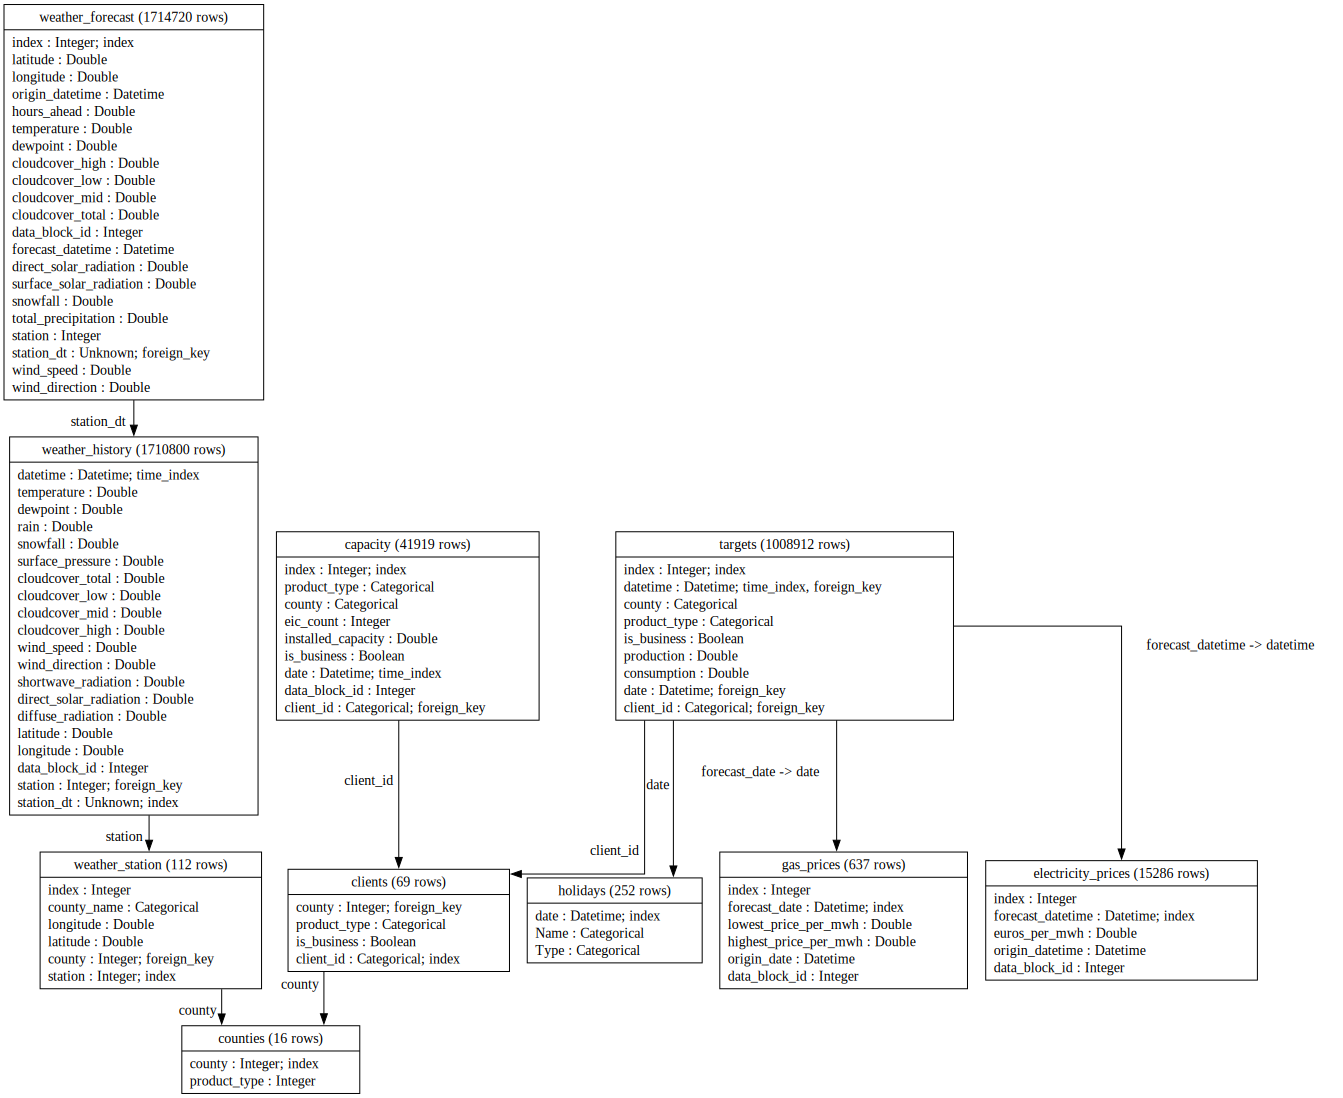

In [21]:
data_schema.plot('/kaggle/working/data_schema.png')

<div>
    <h1 style="font-family:  'Garamond', 'Lucida Sans', sans-serif; text-align: center; color: #263A29; font-weight: bold; font-size: 36px;">
    Feature Engineering
    </h1>
</div>
<hr>

# [Dask-ML](https://ml.dask.org/compose.html)

[Encode Cyclical Features](https://www.kaggle.com/code/avanwyk/encoding-cyclical-features-for-deep-learning)

In [22]:
from woodwork.column_schema import ColumnSchema
from featuretools.primitives import TransformPrimitive

class DateCyclicEncode(TransformPrimitive):
    """
    Return the 10 values from Sine / Cosine for 
        Day-of-Week / Day-of-Month / Day-of-Year / 
        Week-of-Year / Month
    from Datetime
    """
    name = "date_cyclic_encode"
    input_types = [ColumnSchema(logical_type=Datetime)]
    return_type = ColumnSchema(semantic_tags={"numeric"})
    number_output_features = 10
    
    def generate_names(self, base_feature_names):
        base_name = ", ".join(base_feature_names)
        output_names = [
            f"{func.upper()}({dt.upper()}({base_name}))"
                          for dt in ['weekday','day','day_of_year','week','month']
                        for func in ['sin','cos']
        ]
        return output_names
    
    def sin_encode(self, sr, max_val: int):
        return np.sin(2 * np.pi * sr / max_val)

    def cos_encode(self, sr, max_val: int):
        return np.cos(2 * np.pi * sr / max_val)

    def get_function(self):    
        def encode(dt):
            wday = dt.dt.weekday
            mday = dt.dt.day
            yday = dt.dt.dayofyear
            week = dt.dt.isocalendar().week
            month = dt.dt.month
            return [self.sin_encode(wday,   7), self.cos_encode(wday,   7),
                    self.sin_encode(mday,  31), self.cos_encode(mday,  31),
                    self.sin_encode(yday, 366), self.cos_encode(yday, 366),
                    self.sin_encode(week,  52), self.cos_encode(week,  52),
                    self.sin_encode(month, 12), self.cos_encode(month, 12),]
        return encode

[Deep-Feature-Synthesis](https://featuretools.alteryx.com/en/stable/getting_started/afe.html)

In [23]:
trans_primitives = get_default_transform_primitives()
trans_primitives.extend([DateCyclicEncode])

feature_matrix, \
feature_defs = ft.dfs(entityset=data_schema,
                      target_dataframe_name="targets", 
                      trans_primitives=trans_primitives, 
                      max_depth=3,)
feature_matrix

,county,product_type,is_business,production,consumption,client_id,SIN(WEEKDAY(date)),COS(WEEKDAY(date)),SIN(DAY(date)),COS(DAY(date)),...,electricity_prices.SIN(WEEKDAY(origin_datetime)),electricity_prices.COS(WEEKDAY(origin_datetime)),electricity_prices.SIN(DAY(origin_datetime)),electricity_prices.COS(DAY(origin_datetime)),electricity_prices.SIN(DAY_OF_YEAR(origin_datetime)),electricity_prices.COS(DAY_OF_YEAR(origin_datetime)),electricity_prices.SIN(WEEK(origin_datetime)),electricity_prices.COS(WEEK(origin_datetime)),electricity_prices.SIN(MONTH(origin_datetime)),electricity_prices.COS(MONTH(origin_datetime))
index,,,,,,,,,,,,,,,,,,,,,
0,0,0,True,0.000,59.000,C00_P000_B1,0.974928,-0.222521,2.012985e-01,0.97953,...,0.781831,0.62349,-2.449294e-16,1.0,-0.857315,-0.514793,-0.885456,-0.464723,-0.866025,-0.5
1,0,1,False,0.713,96.590,C00_P001_B0,0.974928,-0.222521,2.012985e-01,0.97953,...,0.781831,0.62349,-2.449294e-16,1.0,-0.857315,-0.514793,-0.885456,-0.464723,-0.866025,-0.5
2,0,1,True,0.000,501.760,C00_P001_B1,0.974928,-0.222521,2.012985e-01,0.97953,...,0.781831,0.62349,-2.449294e-16,1.0,-0.857315,-0.514793,-0.885456,-0.464723,-0.866025,-0.5
3,0,2,False,0.000,17.314,C00_P002_B0,0.974928,-0.222521,2.012985e-01,0.97953,...,0.781831,0.62349,-2.449294e-16,1.0,-0.857315,-0.514793,-0.885456,-0.464723,-0.866025,-0.5
4,0,3,False,2.904,656.859,C00_P003_B0,0.974928,-0.222521,2.012985e-01,0.97953,...,0.781831,0.62349,-2.449294e-16,1.0,-0.857315,-0.514793,-0.885456,-0.464723,-0.866025,-0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1008907,15,0,True,0.000,197.233,C15_P000_B1,0.974928,-0.222521,-2.449294e-16,1.00000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1008908,15,1,False,0.004,42.401,C15_P001_B0,0.974928,-0.222521,-2.449294e-16,1.00000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1008909,15,1,True,0.000,28.404,C15_P001_B1,0.974928,-0.222521,-2.449294e-16,1.00000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
feature_defs

[<Feature: county>,
 <Feature: product_type>,
 <Feature: is_business>,
 <Feature: production>,
 <Feature: consumption>,
 <Feature: client_id>,
 <Feature: DATE_CYCLIC_ENCODE(date)>,
 <Feature: DATE_CYCLIC_ENCODE(datetime)>,
 <Feature: DAY(date)>,
 <Feature: DAY(datetime)>,
 <Feature: MONTH(date)>,
 <Feature: MONTH(datetime)>,
 <Feature: WEEKDAY(date)>,
 <Feature: WEEKDAY(datetime)>,
 <Feature: YEAR(date)>,
 <Feature: YEAR(datetime)>,
 <Feature: clients.county>,
 <Feature: clients.product_type>,
 <Feature: clients.is_business>,
 <Feature: holidays.Name>,
 <Feature: holidays.Type>,
 <Feature: gas_prices.index>,
 <Feature: gas_prices.lowest_price_per_mwh>,
 <Feature: gas_prices.highest_price_per_mwh>,
 <Feature: gas_prices.data_block_id>,
 <Feature: electricity_prices.index>,
 <Feature: electricity_prices.euros_per_mwh>,
 <Feature: electricity_prices.data_block_id>,
 <Feature: clients.COUNT(capacity)>,
 <Feature: clients.MAX(capacity.data_block_id)>,
 <Feature: clients.MAX(capacity.eic_cou

[Encode Categorical Features](https://docs.featuretools.com/en/v0.15.0/guides/tuning_dfs.html#encoding-categorical-features)

In [25]:
feature_matrix_enc, features_defs_enc = ft.encode_features(feature_matrix, feature_defs)
feature_matrix_enc

2023-12-21 08:07:50,827 featuretools - WARNING    Feature <Feature: DATE_CYCLIC_ENCODE(date)> has multiple columns and will not be encoded.  This may result in a matrix with non-numeric values.
2023-12-21 08:07:50,828 featuretools - WARNING    Feature <Feature: DATE_CYCLIC_ENCODE(datetime)> has multiple columns and will not be encoded.  This may result in a matrix with non-numeric values.


,is_business,production,consumption,SIN(WEEKDAY(date)),COS(WEEKDAY(date)),SIN(DAY(date)),COS(DAY(date)),SIN(DAY_OF_YEAR(date)),COS(DAY_OF_YEAR(date)),SIN(WEEK(date)),...,electricity_prices.MODE(targets.WEEKDAY(datetime)) = 6,electricity_prices.MODE(targets.WEEKDAY(datetime)) is unknown,electricity_prices.MODE(targets.YEAR(date)) = 2022,electricity_prices.MODE(targets.YEAR(date)) = 2023,electricity_prices.MODE(targets.YEAR(date)) = 2021,electricity_prices.MODE(targets.YEAR(date)) is unknown,electricity_prices.MODE(targets.YEAR(datetime)) = 2022,electricity_prices.MODE(targets.YEAR(datetime)) = 2023,electricity_prices.MODE(targets.YEAR(datetime)) = 2021,electricity_prices.MODE(targets.YEAR(datetime)) is unknown
index,,,,,,,,,,,,,,,,,,,,,
0,True,0.000,59.000,0.974928,-0.222521,2.012985e-01,0.97953,-0.866025,-0.500000,-0.885456,...,False,False,False,False,True,False,False,False,True,False
1,False,0.713,96.590,0.974928,-0.222521,2.012985e-01,0.97953,-0.866025,-0.500000,-0.885456,...,False,False,False,False,True,False,False,False,True,False
2,True,0.000,501.760,0.974928,-0.222521,2.012985e-01,0.97953,-0.866025,-0.500000,-0.885456,...,False,False,False,False,True,False,False,False,True,False
3,False,0.000,17.314,0.974928,-0.222521,2.012985e-01,0.97953,-0.866025,-0.500000,-0.885456,...,False,False,False,False,True,False,False,False,True,False
4,False,2.904,656.859,0.974928,-0.222521,2.012985e-01,0.97953,-0.866025,-0.500000,-0.885456,...,False,False,False,False,True,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1008907,True,0.000,197.233,0.974928,-0.222521,-2.449294e-16,1.00000,0.522133,-0.852864,0.464723,...,False,True,False,False,False,True,False,False,False,True
1008908,False,0.004,42.401,0.974928,-0.222521,-2.449294e-16,1.00000,0.522133,-0.852864,0.464723,...,False,True,False,False,False,True,False,False,False,True
1008909,True,0.000,28.404,0.974928,-0.222521,-2.449294e-16,1.00000,0.522133,-0.852864,0.464723,...,False,True,False,False,False,True,False,False,False,True


In [26]:
features_defs_enc

[<Feature: county = 0>,
 <Feature: county = 11>,
 <Feature: county = 7>,
 <Feature: county = 5>,
 <Feature: county = 15>,
 <Feature: county = 4>,
 <Feature: county = 10>,
 <Feature: county = 14>,
 <Feature: county = 9>,
 <Feature: county = 3>,
 <Feature: county is unknown>,
 <Feature: product_type = 3>,
 <Feature: product_type = 1>,
 <Feature: product_type = 0>,
 <Feature: product_type = 2>,
 <Feature: product_type is unknown>,
 <Feature: is_business>,
 <Feature: production>,
 <Feature: consumption>,
 <Feature: client_id = C15_P003_B1>,
 <Feature: client_id = C15_P003_B0>,
 <Feature: client_id = C15_P001_B1>,
 <Feature: client_id = C15_P001_B0>,
 <Feature: client_id = C14_P003_B1>,
 <Feature: client_id = C14_P003_B0>,
 <Feature: client_id = C14_P001_B1>,
 <Feature: client_id = C14_P001_B0>,
 <Feature: client_id = C13_P003_B1>,
 <Feature: client_id = C13_P003_B0>,
 <Feature: client_id is unknown>,
 <Feature: DATE_CYCLIC_ENCODE(date)>,
 <Feature: DATE_CYCLIC_ENCODE(datetime)>,
 <Feature:

In [27]:
feature_defs

[<Feature: county>,
 <Feature: product_type>,
 <Feature: is_business>,
 <Feature: production>,
 <Feature: consumption>,
 <Feature: client_id>,
 <Feature: DATE_CYCLIC_ENCODE(date)>,
 <Feature: DATE_CYCLIC_ENCODE(datetime)>,
 <Feature: DAY(date)>,
 <Feature: DAY(datetime)>,
 <Feature: MONTH(date)>,
 <Feature: MONTH(datetime)>,
 <Feature: WEEKDAY(date)>,
 <Feature: WEEKDAY(datetime)>,
 <Feature: YEAR(date)>,
 <Feature: YEAR(datetime)>,
 <Feature: clients.county>,
 <Feature: clients.product_type>,
 <Feature: clients.is_business>,
 <Feature: holidays.Name>,
 <Feature: holidays.Type>,
 <Feature: gas_prices.index>,
 <Feature: gas_prices.lowest_price_per_mwh>,
 <Feature: gas_prices.highest_price_per_mwh>,
 <Feature: gas_prices.data_block_id>,
 <Feature: electricity_prices.index>,
 <Feature: electricity_prices.euros_per_mwh>,
 <Feature: electricity_prices.data_block_id>,
 <Feature: clients.COUNT(capacity)>,
 <Feature: clients.MAX(capacity.data_block_id)>,
 <Feature: clients.MAX(capacity.eic_cou